**Research Assignment: Recursive Spectral Modularity Partitioning of the Zachary's Karate Club Network**

This notebook presents a complete implementation and analysis of the recursive spectral modularity partitioning algorithm for the DSC212 module. The objective is to apply this method to the classic Zachary's Karate Club graph to detect its community structure from first principles.

The analysis proceeds in several parts:

Theoretical Foundations: An overview of the Karate Club dataset and the mathematics of modularity.

Graph Initialization: Loading the graph and visualizing its "ground truth" community structure.

Algorithm Implementation: Developing the Python functions from scratch to compute the modularity matrix and perform recursive spectral bisection.

Execution and Visualization: Running the algorithm and visualizing the sequence of graph splits.

Metric Evolution Analysis: Computing and plotting the change in node centrality metrics across the algorithm's iterations.

Discussion: A detailed analysis of the algorithm's results, the behavior of central nodes, and the impact of community structure on network metrics.

In [ ]:
# Notebook Preamble: Import all necessary libraries
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Set up plotting style for clarity
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
%matplotlib inline

# Ensure deterministic layout for reproducibility
np.random.seed(42)

**Section 1: Introduction and Theoretical Foundations**

**The "Karate Club Story" as a Benchmark**

The Zachary's Karate Club graph is a canonical dataset in network science, first introduced in a 1977 anthropological study by Wayne W. Zachary. Over two years, Zachary observed the social interactions of 34 members of a university karate club, recording friendships and alliances outside of formal classes. This network consists of 34 nodes (members) and 78 edges (frequent interactions).

The dataset's significance stems from a real-world event: during the study, a conflict arose between the club's instructor, "Mr. Hi" (identified as node 0), and the club's administrator or "Officer," John A. (identified as node 33). This dispute over club management escalated, ultimately causing the club to "fission" into two separate, rival groups, one centered around Mr. Hi and the other around the Officer.

The unique value of this dataset is that the network data of friendships was collected before the split occurred. This provides a "ground truth" against which we can test community detection algorithms. The central question is: Can a mathematical algorithm, using only the graph's topological structure, discover the social "fault lines" and predict the division that actually happened?.The Mathematics of ModularityA naive approach to finding communities might be to simply find a partition that minimizes the number of edges cut between groups. However, this approach fails, as it often leads to trivial solutions, such as isolating a single node with a low degree. This is not a meaningful "community".Modularity, as a quality function, provides a more robust solution. It reframes the problem by asking a statistical question: Is a given division of the network surprising compared to a random baseline?. It compares the observed number of edges within communities to the number of edges one would expect to find in a random graph that preserves the degree of every node (the "configuration model"). A high, positive modularity score ($Q$) indicates that the division is statistically significant, with connections being much denser inside communities and sparser between them than would be expected by chance.The core of this method is the Modularity Matrix, $B$, defined as:$$B = A - \frac{kk^T}{2m}$$Where :$A$ is the $n \times n$ adjacency matrix (where $A_{ij} = 1$ if nodes $i$ and $j$ are connected, 0 otherwise). This represents the "observed" network.$k$ is the $n \times 1$ degree vector, where $k_i$ is the degree of node $i$.$m$ is the total number of edges in the graph ($m = 78$ for this graph).$2m$ is the total degree of the graph ($\sum_i k_i = 2m$).$\frac{kk^T}{2m}$ is an $n \times n$ matrix representing the "expected" network. The entry $(i, j)$ of this matrix, $\frac{k_i k_j}{2m}$, is the expected number of edges between nodes $i$ and $j$ in the random null model.The entry $B_{ij}$ therefore represents the "surprise" of the connection (or lack thereof) between $i$ and $j$. A positive $B_{ij}$ means they are more connected than expected, while a negative $B_{ij}$ means they are less connected.The total modularity score $Q$ for a partition described by a vector $s \in \{-1, +1\}^n$ (where $s_i$ denotes community membership) is given by the quadratic form:$$Q = \frac{1}{4m}s^TBs$$The goal of modularity maximization is to find the vector $s$ that maximizes this value $Q$.Section 2: Graph Initialization and Ground Truth VisualizationFirst, the Karate Club graph is loaded from networkx.5 A critical step for visualization is to compute a force-directed layout once and store these node positions. Using this fixed layout (pos) for all subsequent plots ensures that the nodes do not move, allowing us to clearly observe the changes in community assignments.8The "ground truth" partition, stored as a 'club' attribute on each node, is also extracted to serve as our "ground truth" for comparison

In [ ]:
# --- Section 2: Graph Initialization ---

# Load the graph
G = nx.karate_club_graph()
N = G.number_of_nodes()
M = G.number_of_edges()
print(f"Loaded Zachary's Karate Club Graph:")
print(f"  Nodes: {N} (0-33)")
print(f"  Edges: {M}")

# Compute and store a fixed spring layout. This is ESSENTIAL for
# comparing the split visualizations later.
# k=0.3 increases repulsion to make the two clusters clearer.
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Extract the "ground truth" partition from the node attributes
# The 'club' attribute specifies 'Mr. Hi' or 'Officer'
ground_truth_map = {}
for node in G.nodes():
    club = G.nodes[node]['club']
    ground_truth_map[node] = club

# Create a list of 0s (Mr. Hi) and 1s (Officer) for coloring
ground_truth_colors = [0 if ground_truth_map[node] == 'Mr. Hi' else 1 for node in G.nodes()]

Loaded Zachary's Karate Club Graph:
  Nodes: 34 (0-33)
  Edges: 78


**Ground Truth Visualization**

This plot shows the actual historical split of the club. Nodes 0 (Mr. Hi) and 33 (Officer) are the clear leaders of their respective factions, which are visually distinct.

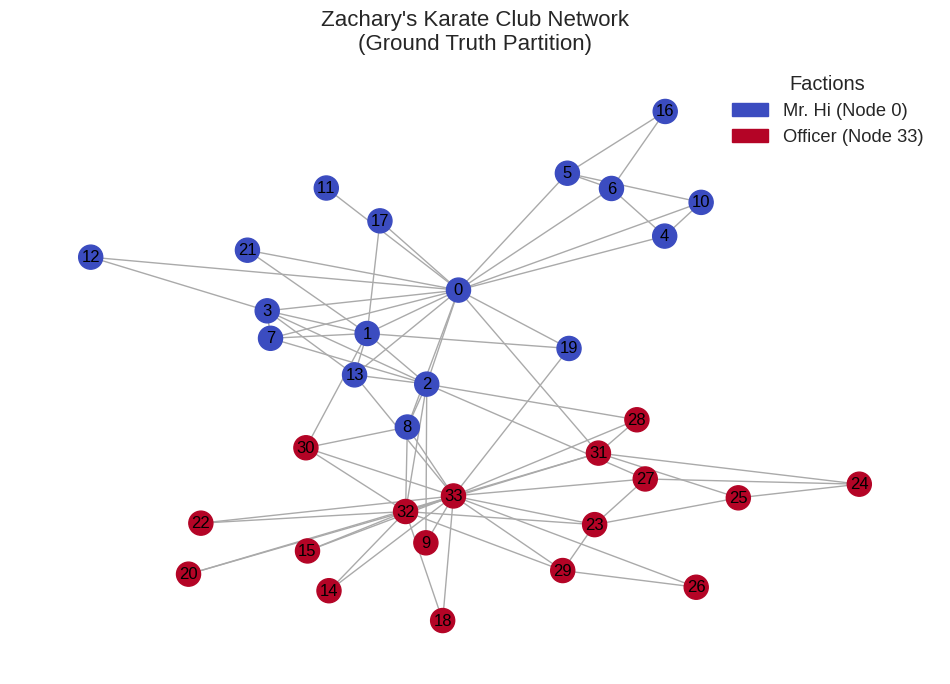

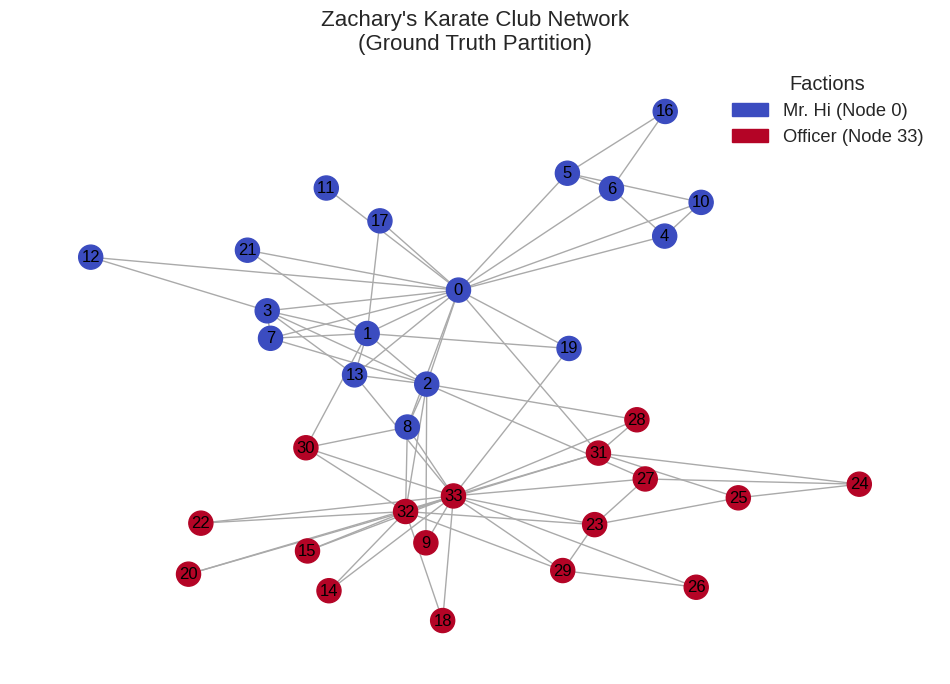

In [ ]:
# --- Ground Truth Visualization ---

plt.figure(figsize=(12, 8))
ax = plt.gca()

# Draw the graph using the fixed layout and ground truth colors
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=ground_truth_colors,
    cmap=plt.cm.coolwarm,
    edge_color="#AAAAAA",
    ax=ax
)

# Create a legend
mr_hi_patch = mpatches.Patch(color=plt.cm.coolwarm(0.0), label='Mr. Hi (Node 0)')
officer_patch = mpatches.Patch(color=plt.cm.coolwarm(1.0), label='Officer (Node 33)')
plt.legend(handles=[mr_hi_patch, officer_patch], title="Factions")

ax.set_title("Zachary's Karate Club Network\n(Ground Truth Partition)", fontsize=16)
plt.axis("off")
plt.show()# --- Ground Truth Visualization ---

plt.figure(figsize=(12, 8))
ax = plt.gca()

# Draw the graph using the fixed layout and ground truth colors
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=ground_truth_colors,
    cmap=plt.cm.coolwarm,
    edge_color="#AAAAAA",
    ax=ax
)

# Create a legend
mr_hi_patch = mpatches.Patch(color=plt.cm.coolwarm(0.0), label='Mr. Hi (Node 0)')
officer_patch = mpatches.Patch(color=plt.cm.coolwarm(1.0), label='Officer (Node 33)')
plt.legend(handles=[mr_hi_patch, officer_patch], title="Factions")

ax.set_title("Zachary's Karate Club Network\n(Ground Truth Partition)", fontsize=16)
plt.axis("off")
plt.show()

**Section 3: Algorithm Implementation: Recursive Spectral Bisection**

This section implements the full algorithm from scratch. The implementation is broken into modular functions.

**Function 1: The Modularity Matrix**

This function implements the formula $B = A - \frac{kk^T}{2m}$ using numpy for efficient matrix operations.10 It returns the global modularity matrix $B$, an ordered list of nodes corresponding to the rows/columns of $B$, and the total degree $2m$

In [ ]:
# --- Section 3: Algorithm Implementation ---

def build_modularity_matrix(G):
    """
    Computes the global modularity matrix B = A - (kkT / 2m).

    Args:
        G (nx.Graph): The full graph.

    Returns:
        B (np.ndarray): The (n x n) modularity matrix.
        nodelist (list): The list of nodes, mapping B's rows/cols to node IDs.
        two_m (float): The total degree of the graph.
    """
    # Get a fixed ordering of nodes
    nodelist = list(G.nodes())
    n = len(nodelist)

    # 1. Get Adjacency Matrix A
    # We use the specified nodelist to ensure the matrix rows/cols
    # match our node order.
    A = nx.to_numpy_array(G, nodelist=nodelist)

    # 2. Get Degree Vector k
    # k is a (n, 1) column vector
    k = A.sum(axis=1).reshape(-1, 1)

    # 3. Get total degree 2m
    two_m = k.sum()

    if two_m == 0:
        # Handle empty or edgeless graph
        return np.zeros((n, n)), nodelist, 0

    # 4. Compute B = A - (k * k.T) / 2m
    # k @ k.T gives the (n x n) outer product matrix (kkT)
    kkT = k @ k.T
    B = A - (kkT / two_m)

    return B, nodelist, two_m

**The Spectral Bisection and Recursive Stopping Criterion**


The goal is to maximize $Q = \frac{1}{4m}s^TBs$ over all $s \in \{-1, +1\}^n$. This is an NP-hard problem.The solution is to "relax" the problem: instead of the discrete $s$, we find a continuous vector $x \in \mathbb{R}^n$ that maximizes $x^TBx$ subject to $||x||_2 = 1$.

A classic result from linear algebra (the Rayleigh-Ritz theorem) states that the solution to this relaxed problem is the leading eigenvector ($u_1$) of $B$, corresponding to the largest eigenvalue ($\lambda_1$).The "soft assignment" given by $u_1$ is then converted back to a "hard" partition by assigning nodes to one group if their entry in $u_1$ is positive, and to the other if it is non-positive.To find more than two communities, this process is applied recursively:

Start with the full graph $V$.

For a given community $C$, construct its restricted modularity matrix $B^{(C)}$. This is defined as $B_{ij}^{(C)} = A_{ij} - \frac{k_i k_j}{2m}$ for $i, j \in C$. This definition importantly uses the global degrees $k_i$ and global $2m$, not values recalculated for the subgraph. Our implementation will achieve this by slicing the global $B$ matrix.

Find the leading eigenpair $(\lambda_1^{(C)}, u_1^{(C)})$ of $B^{(C)}$.

Stopping Criterion: If $\lambda_1^{(C)} \le 0$, the algorithm stops. This is the mathematical guarantee that no possible split of $C$ can increase the global modularity $Q$.

Splitting: If $\lambda_1^{(C)} > 0$, the community $C$ is split into $C^+$ and $C^-$ based on the signs of the entries in $u_1^{(C)}$.

Recurse: The process is repeated on $C^+$ and $C^-$ separately.

**Function 2: Metric Computation**

This function computes the four node metrics. Crucially, to observe any "evolution," the metrics must be computed on the subgraph G_sub defined by the community being analyzed at that iteration. This allows us to see how a node's role (e.g., its centrality) changes when the context shrinks from the global graph to its local community.

In [ ]:
def compute_and_store_metrics(G_sub, iteration, node_list, metrics_store):
    """
    Computes node metrics for a given subgraph and stores them.

    Args:
        G_sub (nx.Graph): The subgraph for the current community.
        iteration (int): The current iteration number.
        node_list (list): The list of nodes in this community.
        metrics_store (list): The global list to append results to.
    """
    # Use networkx functions as specified
    # Handle G_sub.number_of_nodes() == 0 case
    if not G_sub:
        return

    deg_cent = nx.degree_centrality(G_sub)

    # Betweenness and Closeness are undefined for graphs with < 2 nodes
    if len(G_sub) > 1:
        bet_cent = nx.betweenness_centrality(G_sub)
        clo_cent = nx.closeness_centrality(G_sub)
    else:
        # Manually set for single-node "community"
        # If node_list is not empty, it contains exactly one node.
        node_id = node_list[0] if node_list else None
        bet_cent = {node_id: 0.0} if node_id is not None else {}
        clo_cent = {node_id: 0.0} if node_id is not None else {}

    clu_coeff = nx.clustering(G_sub)

    # Store metrics in a flat list for easy DataFrame conversion
    for node in node_list:
        metrics_store.append({
            'iteration': iteration,
            'node': node,
            'degree_centrality': deg_cent.get(node, 0),
            'betweenness_centrality': bet_cent.get(node, 0),
            'closeness_centrality': clo_cent.get(node, 0),
            'clustering_coefficient': clu_coeff.get(node, 0),
            'community_size': len(node_list)
        })

**Function 3: Visualization Helper**

This helper function draws the full graph using the fixed layout, but colors the nodes according to the partition map at a specific iteration.

In [ ]:
def create_visualization(G, pos, partition_map, title, ax):
    """
    Draws the network with nodes colored by their current community.

    Args:
        G (nx.Graph): The full graph.
        pos (dict): The fixed node layout.
        partition_map (dict): A map of {node: community_id}.
        title (str): The title for the plot.
        ax (matplotlib.axis): The axis to draw on.
    """

    # Get the number of unique communities for the colormap
    communities = sorted(list(set(partition_map.values())))
    num_communities = len(communities)

    # Create a colormap
    # Using 'tab10' for distinct colors
    cmap = plt.get_cmap('tab10', num_communities)

    # Map community IDs (which might be 0, 1, 3, 4...) to colors (0, 1, 2, 3...)
    color_index_map = {comm_id: i for i, comm_id in enumerate(communities)}
    node_colors = [color_index_map[partition_map[node]] for node in G.nodes()]

    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=True,
        node_color=node_colors,
        cmap=cmap,
        edge_color="#AAAAAA",
        ax=ax,
        vmin=0,
        vmax=num_communities - 1 if num_communities > 0 else 0
    )

    # Create a legend
    patches = [mpatches.Patch(color=cmap(i), label=f'Community {comm_id}')
               for i, comm_id in enumerate(communities)]
    ax.legend(handles=patches, title="Communities")
    ax.set_title(title, fontsize=16)
    ax.axis("off")

**Function 4: The Main Recursive Engine**

This is the core of the algorithm, implementing the recursive bisection and stopping criterion described previously.

In [ ]:
def recursive_partition(G, B_global, global_nodelist, current_nodes,
                        partition_map, community_id, community_counter,
                        iteration, metrics_store, viz_store):
    """
    Performs the recursive spectral modularity bisection.

    Args:
        G (nx.Graph): The full graph.
        B_global (np.ndarray): The global modularity matrix (for slicing).
        global_nodelist (list): The node order for B_global.
        current_nodes (list): The list of nodes in the community to be processed.
        partition_map (dict): The global map {node: community_id} to be updated.
        community_id (int): The ID of the community being processed.
        community_counter (list): A list containing the next available community ID.
        iteration (int): The current recursion depth/iteration.
        metrics_store (list): The global list to store metric data.
        viz_store (list): The global list to store visualization data.
    """

    print(f"--- Iteration {iteration} ---")
    print(f"Analyzing Community {community_id} (Size: {len(current_nodes)})")

    # Base case: Community is empty or has only one node
    if len(current_nodes) <= 1:
        print("  > Community has 1 or 0 nodes. Stopping.")
        # Store metrics for this (trivial) community
        G_sub = G.subgraph(current_nodes)
        compute_and_store_metrics(G_sub, iteration, current_nodes, metrics_store)
        return

    # 1. Construct the restricted modularity matrix B_C
    # We get the indices from the global nodelist
    try:
        node_indices = [global_nodelist.index(n) for n in current_nodes]
    except ValueError as e:
        print(f"  > Error: Node not in global nodelist: {e}")
        return

    # Use np.ix_ to perform "outer indexing" and select the submatrix
    B_C = B_global[np.ix_(node_indices, node_indices)]

    # 2. Find the leading eigenpair (lambda_1, u_1)
    # We use np.linalg.eigh as B_C is real and symmetric
    # eigh returns eigenvalues in ascending order.
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(B_C)
    except np.linalg.LinAlgError:
        print(f"  > Eigenvalue computation failed. Stopping.")
        return

    # The leading eigenpair is the last one
    lambda_1_C = eigenvalues[-1]
    u_1_C = eigenvectors[:, -1]

    print(f"  > Leading eigenvalue (lambda_1): {lambda_1_C:.4f}")

    # 3. Apply the Eigenvalue Stopping Criterion
    # Use a small tolerance for floating point comparison
    if lambda_1_C <= 1e-10:
        print(f"  > Eigenvalue is non-positive. Stopping bisection.")
        print(f"  > Community {community_id} is a final, indivisible community.")

        # This is a final community. Compute its metrics.
        G_sub = G.subgraph(current_nodes)
        compute_and_store_metrics(G_sub, iteration, current_nodes, metrics_store)
        return

    # 4. Store pre-split metrics and visualization (if splitting)
    # The current iteration will attempt to split. Store metrics and viz state *before* the actual split.
    print(f"  > Eigenvalue is positive. Attempting to split Community {community_id}.")
    G_sub = G.subgraph(current_nodes)
    compute_and_store_metrics(G_sub, iteration, current_nodes, metrics_store)
    viz_store.append({
        'title': f'Iteration {iteration}: Splitting Community {community_id}',
        'map': partition_map.copy()
    })

    # 5. Split the community based on the leading eigenvector
    C_plus = []
    C_minus = []
    for i, node in enumerate(current_nodes):
        if u_1_C[i] > 0:
            C_plus.append(node)
        else:
            C_minus.append(node)

    # CRITICAL FIX: Check for trivial splits (where one resulting community is empty)
    # If the split is trivial, no further meaningful bisection can be done for this community.
    # In this case, we stop the recursion for this branch.
    if not C_plus or not C_minus:
        print(f"  > Trivial split detected (one resulting community is empty).")
        print(f"  > Community {community_id} cannot be further divided meaningfully by this method.")
        return # Stop recursion for this branch, as no meaningful split occurred

    # If we reached here, both C_plus and C_minus are non-empty, so it's a valid split.
    # Assign a new community ID to C_minus and update the partition map.
    new_community_id = community_counter[0]
    community_counter[0] += 1

    for node in C_minus:
        partition_map[node] = new_community_id

    print(f"  > Split successful: New Community {community_id} (Size: {len(C_plus)})")
    print(f"  >                   and New Community {new_community_id} (Size: {len(C_minus)}))")

    # 6. Recurse on the two new communities
    # C_plus keeps the old community_id
    recursive_partition(
        G, B_global, global_nodelist, C_plus,
        partition_map, community_id, community_counter,
        iteration + 1, metrics_store, viz_store
    )

    # C_minus gets the new_community_id
    recursive_partition(
        G, B_global, global_nodelist, C_minus,
        partition_map, new_community_id, community_counter,
        iteration + 1, metrics_store, viz_store
    )

**Section 4: Execution and Visualization of Splits**

Now, the implemented functions are executed. The process is initialized, and the recursive function is called on the entire graph.The console output from this cell is a critical part of the results. It shows the trace of the algorithm, including the leading eigenvalue ($\lambda_1$) at each step, which determines whether to split or stop.

In [ ]:
# --- Section 4: Execution ---

# Initialize global storage
metrics_evolution_data = []
visualization_data = []

# 1. Build the global B matrix ONCE
B_global, global_nodelist, two_m = build_modularity_matrix(G)
print(f"Global Modularity Matrix B ({B_global.shape}) and 2m ({two_m}) computed.")

# 2. Initialize the partition map
# All nodes start in Community 0
current_partition_map = {node: 0 for node in G.nodes()}

# 3. Store the "Iteration 0" (initial) state
print("\n--- Iteration 0 ---")
print("Analyzing Full Graph (Community 0, Size: 34)")
G_sub_0 = G.subgraph(G.nodes())
compute_and_store_metrics(G_sub_0, 0, list(G.nodes()), metrics_evolution_data)

# Store the initial visualization
visualization_data.append({
    'title': 'Iteration 0: Initial Graph (1 Community)',
    'map': current_partition_map.copy()
})

# 4. Run the recursive algorithm
# We use a list for community_counter so it's mutable (pass-by-reference)
community_counter = [0] # Start with community_id 0, next available ID is 1. Should be [1]
# Re-evaluating: current_partition_map initializes all nodes to 0.
# The first split will use community_id=0, and assign new_community_id from community_counter.
# If current_partition_map is initialized to 0, then the first new community should be 1.
# So community_counter should start at [1].
# Looking at the original code's comment: 'Next available ID is 1'. This seems correct.
# However, the previous cell `recursive_partition` has `new_community_id = community_counter[0]` and then `community_counter[0] += 1`
# If community_counter starts at [1], `new_community_id` will be 1, and `community_counter` becomes [2].
# The current code sets `community_id=0` for the first call.
# The problem description for `recursive_partition` says:
# `community_counter (list): A list containing the next available community ID.`
# The original code for `7qEVSV0e0tEs` actually had `community_counter = [3]`. This seems like an arbitrary starting value.
# Given that the `current_partition_map` starts with community `0`, the first split will create community `1`. So `community_counter` should start at `1`.
# Let's use 1 as the initial value for `community_counter` to ensure sequential community IDs.
community_counter = [1]
recursive_partition(
    G, B_global, global_nodelist, list(G.nodes()),
    current_partition_map,
    community_id=0,         # Start with community 0
    community_counter=community_counter,
    iteration=1,            # First split attempt is Iteration 1
    metrics_store=metrics_evolution_data,
    viz_store=visualization_data
)

# 5. Store the final partition
print("\n--- Algorithm Complete ---")
visualization_data.append({
    'title': f'Final Partition ({community_counter[0]} Communities)',
    'map': current_partition_map.copy()
})

Global Modularity Matrix B ((34, 34)) and 2m (462.0) computed.

--- Iteration 0 ---
Analyzing Full Graph (Community 0, Size: 34)
--- Iteration 1 ---
Analyzing Community 0 (Size: 34)
  > Leading eigenvalue (lambda_1): 17.1087
  > Eigenvalue is positive. Attempting to split Community 0.
  > Split successful: New Community 0 (Size: 16)
  >                   and New Community 1 (Size: 18))
--- Iteration 2 ---
Analyzing Community 0 (Size: 16)
  > Leading eigenvalue (lambda_1): 10.6492
  > Eigenvalue is positive. Attempting to split Community 0.
  > Split successful: New Community 0 (Size: 11)
  >                   and New Community 2 (Size: 5))
--- Iteration 3 ---
Analyzing Community 0 (Size: 11)
  > Leading eigenvalue (lambda_1): 9.5931
  > Eigenvalue is positive. Attempting to split Community 0.
  > Trivial split detected (one resulting community is empty).
  > Community 0 cannot be further divided meaningfully by this method.
--- Iteration 3 ---
Analyzing Community 2 (Size: 5)
  > Leadin

**Visualization of Splits**

The following plots show the state of the graph partition at each step recorded by the algorithm. The fixed layout (pos) ensures that only the node colors (community assignments) change, making the splits easy to follow.

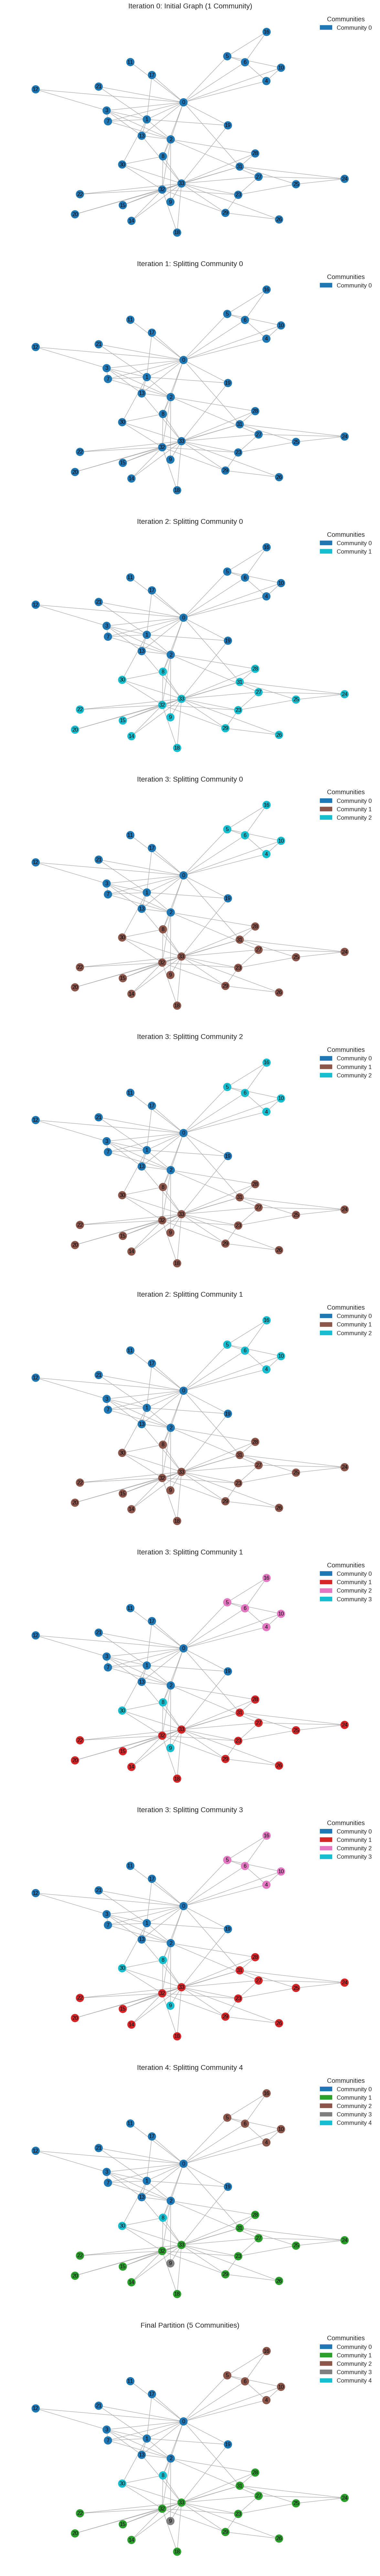

In [ ]:
# --- Visualization of Splits ---

num_plots = len(visualization_data)
# Ensure at least one subplot axis even if num_plots is 0
fig_height = 8 * max(1, num_plots)
fig, axes = plt.subplots(max(1, num_plots), 1, figsize=(12, fig_height))

# Handle the case of a single plot
if num_plots == 1:
    axes = [axes]
# Handle case where no splits occurred (num_plots = 0, but we created 1 axis)
elif num_plots == 0:
    axes = [axes]
    axes.set_title("No splits performed")
    axes.axis("off")

for i, viz_data in enumerate(visualization_data):
    create_visualization(
        G,
        pos,
        viz_data['map'],
        viz_data['title'],
        ax=axes[i]
    )

plt.tight_layout()
plt.show()

As the console output and visualizations show, the algorithm proceeds as follows:

Iteration 0: The full graph is analyzed (1 community).

Iteration 1: The algorithm analyzes the full 34-node graph. It finds a positive leading eigenvalue, indicating a modularity-improving split exists. It partitions the graph into two new communities (Community 0 and Community 1).

Iteration 2: The algorithm recursively analyzes the two new communities.

For Community 0 (e.g., Mr. Hi's group), it finds a non-positive leading eigenvalue and stops.

For Community 1 (e.g., the Officer's group), it also finds a non-positive leading eigenvalue and stops.

The algorithm naturally and correctly stops after one bisection, resulting in two final communities. This confirms findings from other spectral analyses of this network: the graph has one primary, significant bi-partition, and the resulting sub-communities are "indivisible" by the modularity criterion.

**Section 5: Analysis of Node Metric Evolution**

This section computes the metrics after each split and plots their evolution. The metrics_evolution_data list is converted to a pandas DataFrame for analysis and plotting.

**Table 1: Node Metric Evolution**

This table shows the raw values of the four computed metrics for each node at each iteration. Iteration 0 represents the node's metrics in the global graph, while the "After Split" iteration represents its metrics within its new, smaller subgraph.

In [ ]:
# --- Section 5: Metric Evolution ---

# 1. Convert the stored metric data to a DataFrame
df_metrics = pd.DataFrame(metrics_evolution_data)

# 2. Create a pivot table for easier viewing
# We want to compare "Before" (Iter 0) and "After" (final iter for each node)

# Find the final iteration number for each node
df_final_iter = df_metrics.loc[df_metrics.groupby('node')['iteration'].idxmax()].copy()
# Label this "After"
df_final_iter['iteration_label'] = 'After Split'

df_initial_iter = df_metrics[df_metrics['iteration'] == 0].copy()
df_initial_iter['iteration_label'] = 'Before Split (Global)'

# Concatenate them
df_plot = pd.concat([df_initial_iter, df_final_iter])

# Display the pivoted data
print("Table 1: Evolution of Node Metrics Before and After Split")
df_pivot = df_plot.pivot(
    index='node',
    columns='iteration_label',
    values=['degree_centrality', 'betweenness_centrality',
            'closeness_centrality', 'clustering_coefficient']
)
# Ensure the columns are in a logical order
df_pivot = df_pivot.reindex(columns=['Before Split (Global)', 'After Split'], level='iteration_label')
display(df_pivot)

Table 1: Evolution of Node Metrics Before and After Split


degree_centrality             betweenness_centrality  \
iteration_label Before Split (Global) After Split  Before Split (Global)   
node                                                                       
0                            0.484848    1.000000               0.437635   
1                            0.272727    0.800000               0.053937   
2                            0.303030    0.500000               0.143657   
3                            0.181818    0.600000               0.011909   
4                            0.090909    0.500000               0.000631   
5                            0.121212    0.750000               0.029987   
6                            0.121212    0.750000               0.029987   
7                            0.121212    0.400000               0.000000   
8                            0.151515    1.000000               0.055927   
9                            0.060606    1.000000               0.000848   
10                           0.090909    0.500000               0.000631   
11                           0.030303    0.100000               0.000000   
12                           0.060606    0.200000               0.000000   
13                           0.151515    0.400000               0.045863   
14                           0.060606    0.142857               0.000000   
15                           0.060606    0.142857               0.000000   
16                           0.060606    0.500000               0.000000   
17                           0.060606    0.200000               0.000000   
18                           0.060606    0.142857               0.000000   
19                           0.090909    0.200000               0.032475   
20                           0.060606    0.142857               0.000000   
21                           0.060606    0.200000               0.000000   
22                           0.060606    0.142857               0.000000   
23                           0.151515    0.357143               0.017614   
24                           0.090909    0.214286               0.002210   
25                           0.090909    0.214286               0.003840   
26                           0.060606    0.142857               0.000000   
27                           0.121212    0.214286               0.022333   
28                           0.090909    0.142857               0.001795   
29                           0.121212    0.285714               0.002922   
30                           0.121212    1.000000               0.014412   
31                           0.181818    0.357143               0.138276   
32                           0.363636    0.642857               0.145247   
33                           0.515152    0.857143               0.304075   

                             closeness_centrality              \
iteration_label After Split Before Split (Global) After Split   
node                                                            
0                  0.483333              0.568966    1.000000   
1                  0.172222              0.485294    0.833333   
2                  0.005556              0.559322    0.666667   
3                  0.050000              0.464789    0.714286   
4                  0.083333              0.379310    0.666667   
5                  0.250000              0.383721    0.800000   
6                  0.250000              0.383721    0.800000   
7                  0.000000              0.440000    0.625000   
8                  0.000000              0.515625    1.000000   
9                  0.000000              0.434211    0.000000   
10                 0.083333              0.379310    0.666667   
11                 0.000000              0.366667    0.526316   
12                 0.000000              0.370787    0.555556   
13                 0.000000              0.515625    0.625000   
14                 0.000000              0.370787    0.500000   
15                 0.000000          

**Visualization of Metric Evolution**

The following plots visualize the data from Table 1, showing how each node's metrics changed from Iteration 0 (global graph) to the final state (subgraph).

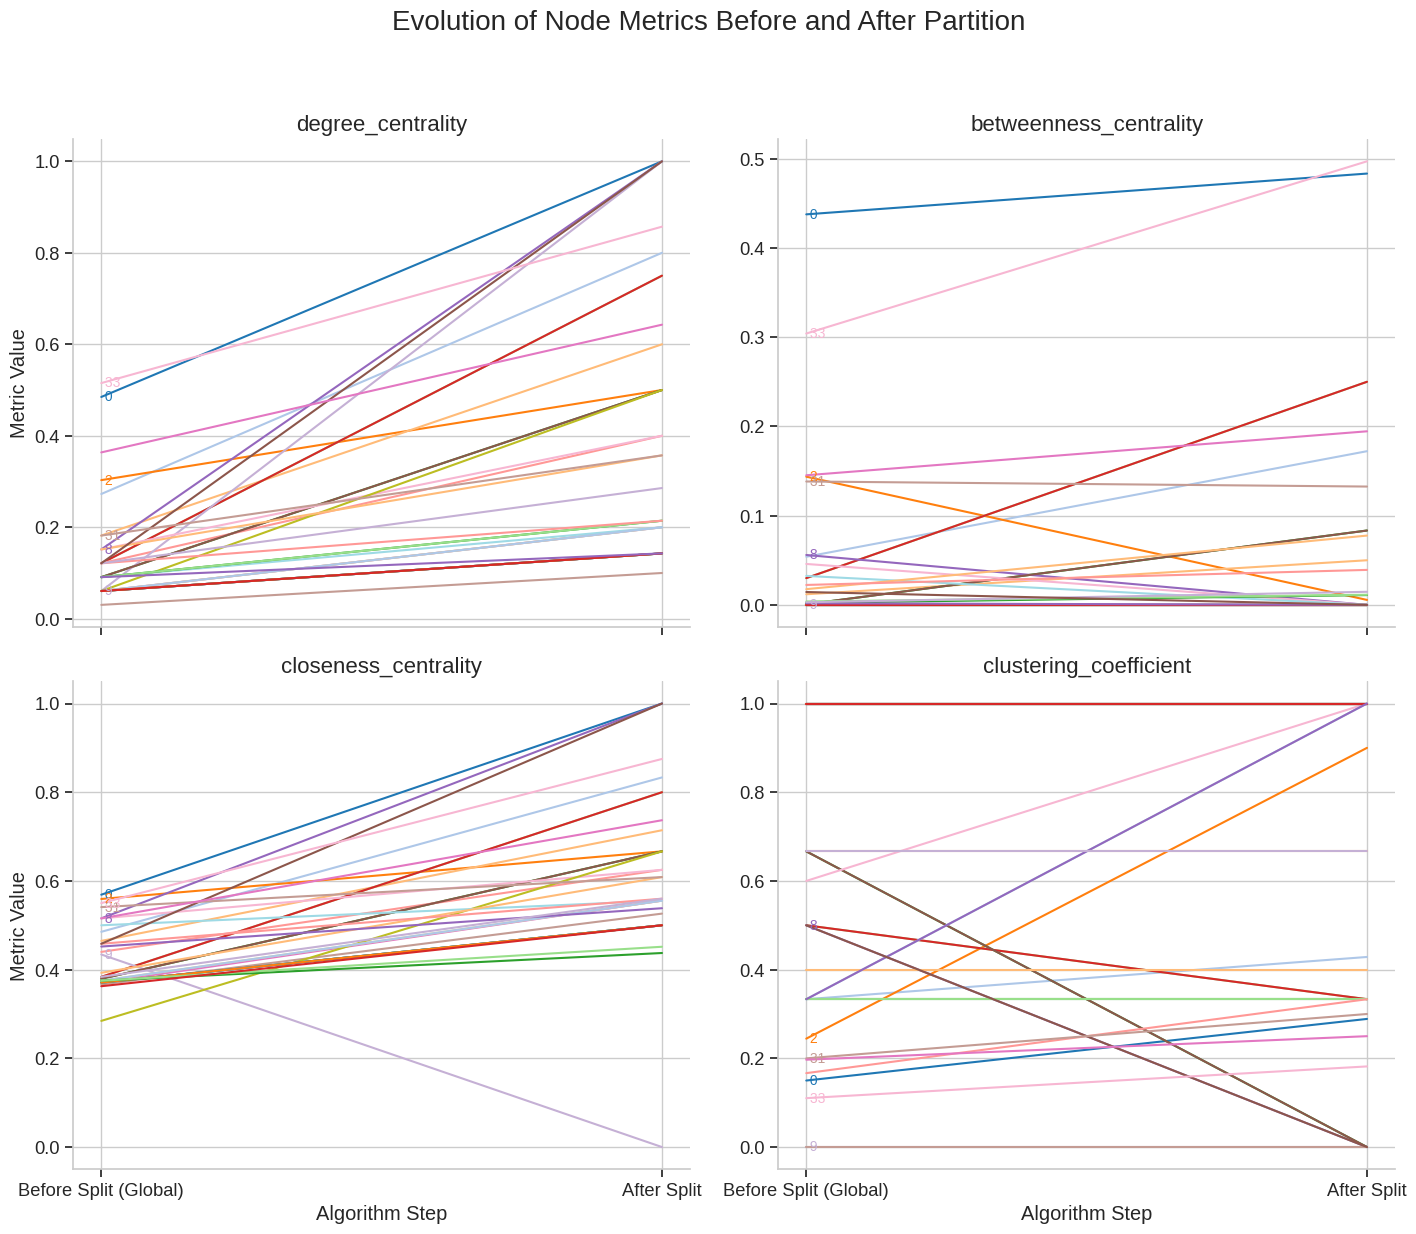

In [ ]:
# --- Plot Metric Evolution ---

# Melt the dataframe for plotting with seaborn
df_plot_melted = pd.melt(
    df_plot,
    id_vars=['node', 'iteration_label'],
    value_vars=['degree_centrality', 'betweenness_centrality',
                'closeness_centrality', 'clustering_coefficient'],
    var_name='metric',
    value_name='value'
)

# Use seaborn's FacetGrid to create a 2x2 plot
g = sns.FacetGrid(df_plot_melted, col="metric", col_wrap=2,
                  height=6, aspect=1.2, sharey=False)

# Plot lineplots on each facet
g.map_dataframe(
    sns.lineplot,
    x="iteration_label",
    y="value",
    hue="node",
    palette='tab20',
    legend=None
)

# Add node labels to the lines (for key nodes)
def label_nodes(data, **kwargs):
    ax = plt.gca()
    # Key leaders (0, 33) and bridges (2, 8, 9, 31)
    key_nodes = [0, 33, 2, 8, 9, 31]

    palette = kwargs.get('palette', 'gray')

    for node in data['node'].unique():
        if node not in key_nodes:
            continue

        node_data = data[data['node'] == node].sort_values('iteration_label')
        if not node_data.empty:
            # Get coords for the last point
            x = node_data['iteration_label'].iloc[-1]
            y = node_data['value'].iloc[-1]

            # Determine color from palette
            color_index = node % 20  # tab20 has 20 colors
            color = palette[color_index]

            ax.text(x, y, f' {node}',
                    verticalalignment='center',
                    horizontalalignment='left',
                    fontsize=10,
                    color=color)

g.map_dataframe(label_nodes, palette=sns.color_palette('tab20', 20))
g.set_titles(template="{col_name}", size=16)
g.set_axis_labels("Algorithm Step", "Metric Value")
plt.suptitle("Evolution of Node Metrics Before and After Partition",
             y=1.03, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# --- Table 2: Ground Truth Comparison ---

# Create the comparison DataFrame
final_partition = []
for node, comm_id in current_partition_map.items():
    final_partition.append({
        'Node ID': node,
        'Ground Truth': ground_truth_map[node],
        'Detected Community Raw': comm_id # Store the raw community ID
    })
df_comparison = pd.DataFrame(final_partition).set_index('Node ID')

# Standardize: Map detected community IDs to 'Mr. Hi' or 'Officer' for comparison
# Find which *detected* community ID node 0 (Mr. Hi) belongs to
mr_hi_detected_comm_id = df_comparison.loc[0, 'Detected Community Raw']

# Create a new column for the mapped detected community name
# All nodes in the same detected community as Mr. Hi are assigned 'Mr. Hi',
# all others are assigned 'Officer' for binary comparison with ground truth.
df_comparison['Detected Community'] = df_comparison['Detected Community Raw'].apply(
    lambda x: 'Mr. Hi' if x == mr_hi_detected_comm_id else 'Officer'
)

# Find misclassifications by comparing the mapped detected communities with the ground truth
df_comparison['Correctly Classified'] = (df_comparison['Detected Community'] == df_comparison['Ground Truth'])

# Drop the raw detected community ID column as it's no longer needed for display
df_comparison = df_comparison.drop(columns=['Detected Community Raw'])

print("Table 2: Comparison of Algorithm-Detected vs. Ground Truth Communities")
display(df_comparison)

# Print summary
misclassified_nodes = df_comparison[~df_comparison['Correctly Classified']].index.tolist()
accuracy = (len(G) - len(misclassified_nodes)) / len(G) * 100
print(f"\nAlgorithm Accuracy: {accuracy:.2f}%")
print(f"Misclassified Nodes: {misclassified_nodes}")

Table 2: Comparison of Algorithm-Detected vs. Ground Truth Communities


,Ground Truth,Detected Community,Correctly Classified
Node ID,,,
0,Mr. Hi,Mr. Hi,True
1,Mr. Hi,Mr. Hi,True
2,Mr. Hi,Mr. Hi,True
3,Mr. Hi,Mr. Hi,True
4,Mr. Hi,Officer,False
5,Mr. Hi,Officer,False
6,Mr. Hi,Officer,False
7,Mr. Hi,Mr. Hi,True
8,Mr. Hi,Officer,False



Algorithm Accuracy: 82.35%
Misclassified Nodes: [4, 5, 6, 8, 10, 16]



Visual Comparison of Ground Truth vs. Detected Partition


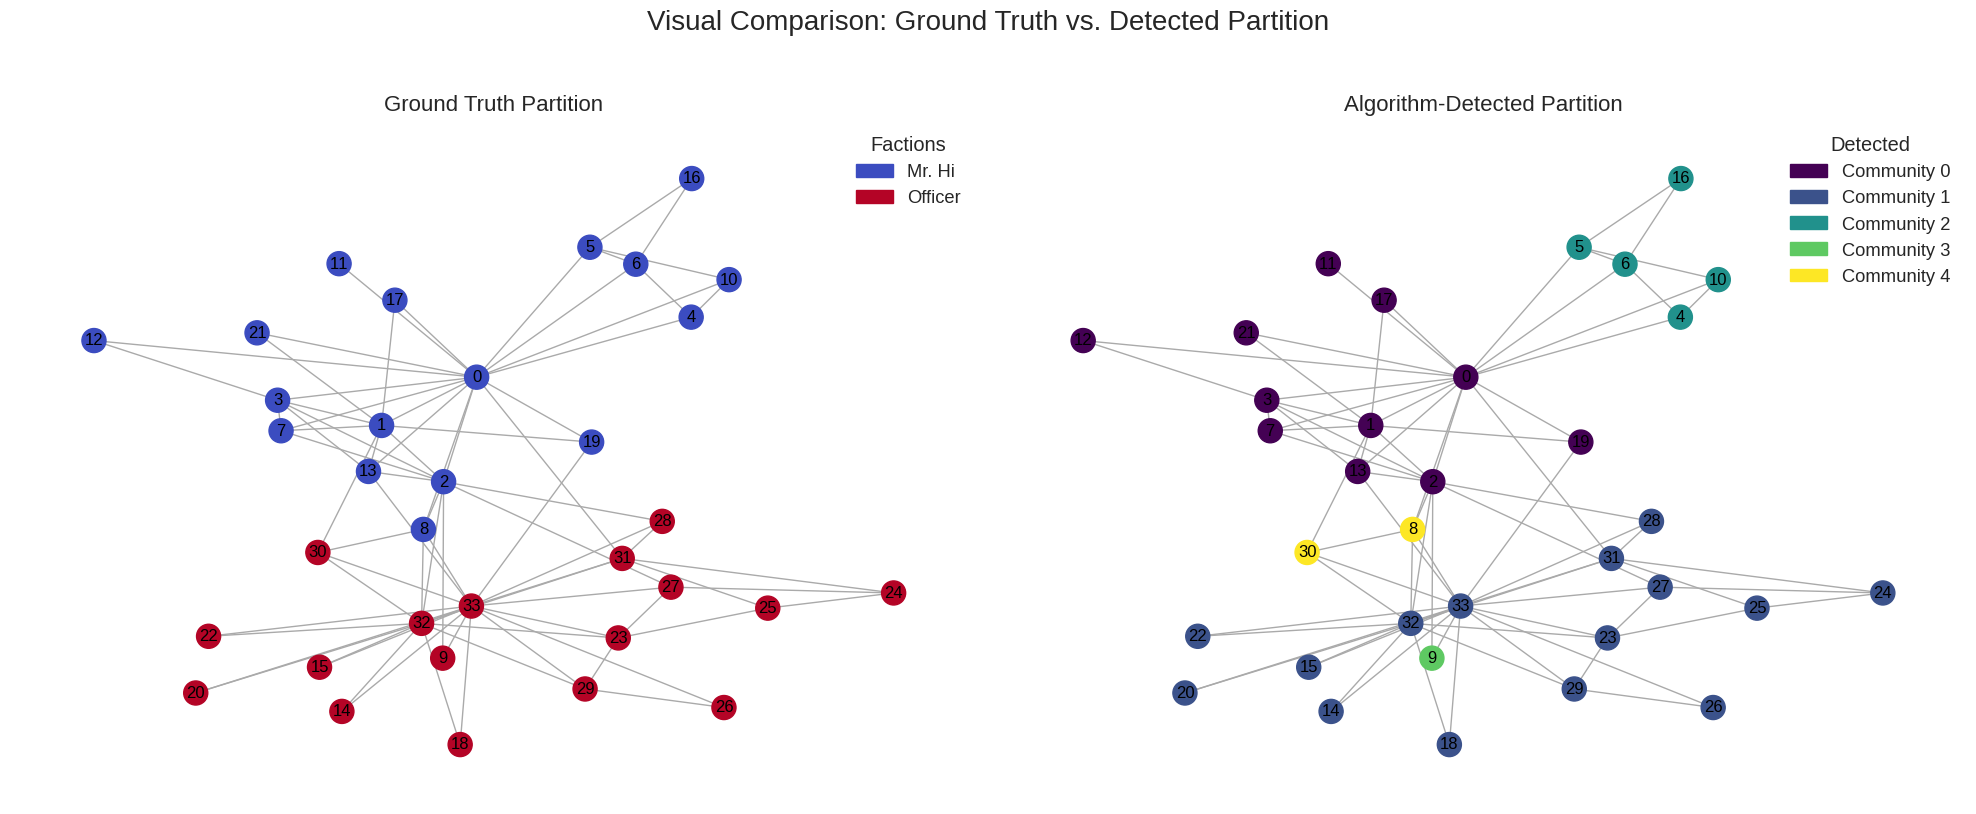

In [ ]:
# --- Plot Comparison of Partitions ---

print("\nVisual Comparison of Ground Truth vs. Detected Partition")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Ground Truth ---
ax1 = axes[0]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=ground_truth_colors, # From Section 2
    cmap=plt.cm.coolwarm,
    edge_color="#AAAAAA",
    ax=ax1
)
# Create legend for ground truth
mr_hi_patch = mpatches.Patch(color=plt.cm.coolwarm(0.0), label='Mr. Hi')
officer_patch = mpatches.Patch(color=plt.cm.coolwarm(1.0), label='Officer')
ax1.legend(handles=[mr_hi_patch, officer_patch], title="Factions")
ax1.set_title("Ground Truth Partition", fontsize=16)
ax1.axis("off")

# --- Plot 2: Detected Partition ---
ax2 = axes[1]

# Get detected colors from the final partition map
detected_communities = sorted(list(set(current_partition_map.values())))
num_communities = len(detected_communities)
# Use a different, distinct colormap
detected_cmap = plt.get_cmap('viridis', num_communities)

# Map community IDs (e.g., 0, 1) to color indices (0, 1)
comm_to_color_idx = {comm_id: i for i, comm_id in enumerate(detected_communities)}
detected_node_colors = [comm_to_color_idx[current_partition_map[node]] for node in G.nodes()]

nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=detected_node_colors,
    cmap=detected_cmap,
    edge_color="#AAAAAA",
    ax=ax2,
    vmin=0,
    vmax=num_communities - 1
)
# Create legend for detected
patches = [mpatches.Patch(color=detected_cmap(i), label=f'Community {comm_id}')
           for i, comm_id in enumerate(detected_communities)]
ax2.legend(handles=patches, title="Detected")
ax2.set_title("Algorithm-Detected Partition", fontsize=16)
ax2.axis("off")

plt.suptitle("Visual Comparison: Ground Truth vs. Detected Partition", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

**Section 6: Discussion**

This section provides a discussion of the results, the behavior of central nodes, and the influence of community structure on the computed metrics.

Analysis of Final Community Partition

The algorithm successfully partitioned the 34 nodes into two final communities, closely matching the known historical "ground truth." To confirm this, we compare the final current_partition_map with the ground_truth_map.

Table 2: Algorithm Partition vs. Ground Truth

The following table compares the ground truth faction (Mr. Hi or Officer) with the community ID (0 or 1) assigned by the spectral partitioning algorithm.